# Imports

In [8]:
using DataFrames
using CSV
using MLJ
using DecisionTree: print_tree
using Plots
using StatsBase

include("../../lib.jl")

ENV["LINES"]=30;

In [9]:
mkdir("Figures/")

LoadError: IOError: mkdir: file already exists (EEXIST)

# Data

In [10]:
data = CSV.read("data.csv")

,1,2,3,4,5,6,7,8,9,10,11
,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64
1,3.919,2.6909,0,0,0,0,0,31.4,2,0,0
2,4.17,2.1144,0,0,0,0,0,30.8,1,1,0
3,3.932,3.2512,0,0,0,0,0,26.7,2,4,0
4,3.0,2.7098,0,0,0,0,0,20.0,0,2,0
5,4.236,3.3944,0,0,0,0,0,29.4,2,4,0
6,4.236,3.4286,0,0,0,0,0,28.6,2,4,0
7,5.0,5.0476,1,0,0,0,0,11.1,0,3,0
8,4.525,3.8301,0,0,0,0,0,31.6,3,2,0
9,4.596,3.0777,0,0,0,0,2,44.4,2,0,0


Look at class labels to see if dataset is imbalanced

In [11]:
label_counts = countmap(data[:(Class)])

Dict{String,Int64} with 2 entries:
  "RB"  => 356
  "NRB" => 699

In [12]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

2-element Array{Float64,1}:
 0.33744075829383885
 0.6625592417061611

Get data ready for training

In [13]:
schema(data)

┌─────────┬─────────┬────────────┐
│ _.names │ _.types │ _.scitypes │
├─────────┼─────────┼────────────┤
│ 1       │ Float64 │ Continuous │
│ 2       │ Float64 │ Continuous │
│ 3       │ Int64   │ Count      │
│ 4       │ Int64   │ Count      │
│ 5       │ Int64   │ Count      │
│ 6       │ Int64   │ Count      │
│ 7       │ Int64   │ Count      │
│ 8       │ Float64 │ Continuous │
│ 9       │ Int64   │ Count      │
│ 10      │ Int64   │ Count      │
│ 11      │ Int64   │ Count      │
│ 12      │ Float64 │ Continuous │
│ 13      │ Float64 │ Continuous │
│ 14      │ Float64 │ Continuous │
│ 15      │ Float64 │ Continuous │
│ 16      │ Int64   │ Count      │
│ 17      │ Float64 │ Continuous │
│ 18      │ Float64 │ Continuous │
│ 19      │ Int64   │ Count      │
│ 20      │ Int64   │ Count      │
│ 21      │ Int64   │ Count      │
│ 22      │ Float64 │ Continuous │
│ 23      │ Int64   │ Count      │
│ 24      │ Int64   │ Count      │
│ 25      │ Int64   │ Count      │
│ 26      │ Int64   

In [14]:
coerce!(data, :Class=>Multiclass)
schema(data)

┌─────────┬─────────────────────────────────┬───────────────┐
│ _.names │ _.types                         │ _.scitypes    │
├─────────┼─────────────────────────────────┼───────────────┤
│ 1       │ Float64                         │ Continuous    │
│ 2       │ Float64                         │ Continuous    │
│ 3       │ Int64                           │ Count         │
│ 4       │ Int64                           │ Count         │
│ 5       │ Int64                           │ Count         │
│ 6       │ Int64                           │ Count         │
│ 7       │ Int64                           │ Count         │
│ 8       │ Float64                         │ Continuous    │
│ 9       │ Int64                           │ Count         │
│ 10      │ Int64                           │ Count         │
│ 11      │ Int64                           │ Count         │
│ 12      │ Float64                         │ Continuous    │
│ 13      │ Float64                         │ Continuous    │
│ 14    

In [15]:
y, X = unpack(data, ==(:Class), colname->true)

(CategoricalValue{String,UInt32}["RB", "RB", "RB", "RB", "RB", "RB", "RB", "RB", "RB", "RB"  …  "NRB", "NRB", "NRB", "NRB", "NRB", "NRB", "NRB", "NRB", "NRB", "NRB"], 1055×41 DataFrame. Omitted printing of 33 columns
│ Row  │ 1       │ 2       │ 3     │ 4     │ 5     │ 6     │ 7     │ 8       │
│      │ Float64 │ Float64 │ Int64 │ Int64 │ Int64 │ Int64 │ Int64 │ Float64 │
├──────┼─────────┼─────────┼───────┼───────┼───────┼───────┼───────┼─────────┤
│ 1    │ 3.919   │ 2.6909  │ 0     │ 0     │ 0     │ 0     │ 0     │ 31.4    │
│ 2    │ 4.17    │ 2.1144  │ 0     │ 0     │ 0     │ 0     │ 0     │ 30.8    │
│ 3    │ 3.932   │ 3.2512  │ 0     │ 0     │ 0     │ 0     │ 0     │ 26.7    │
│ 4    │ 3.0     │ 2.7098  │ 0     │ 0     │ 0     │ 0     │ 0     │ 20.0    │
│ 5    │ 4.236   │ 3.3944  │ 0     │ 0     │ 0     │ 0     │ 0     │ 29.4    │
│ 6    │ 4.236   │ 3.4286  │ 0     │ 0     │ 0     │ 0     │ 0     │ 28.6    │
│ 7    │ 5.0     │ 5.0476  │ 1     │ 0     │ 0     │ 0     │ 0     │ 11.

Partition train and test data accoring to class labels

In [16]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=123, stratify=values(data[:Class])) # gives 70:30 split

([465, 562, 278, 619, 161, 972, 782, 321, 537, 760  …  12, 913, 471, 13, 1006, 802, 112, 840, 744, 261], [196, 586, 245, 77, 1028, 432, 215, 987, 137, 411  …  975, 610, 886, 848, 731, 1024, 805, 500, 659, 415])

In [17]:
train_counts = countmap(data[train,:Class])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

2-element Array{Float64,1}:
 0.33739837398373984
 0.6626016260162602

In [18]:
test_counts = countmap(data[test,:Class])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

2-element Array{Float64,1}:
 0.33753943217665616
 0.6624605678233438

In [19]:
standardizer = Standardizer()
stand = machine(standardizer, X[train,:]) #only want to standardize on training distribution
fit!(stand)
X_stand = MLJ.transform(stand, X);

┌ Info: Training Machine{Standardizer} @873.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [20]:
models(matching(X,y))

6-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_name = MLJModels, ... )
 (name = RandomForestClassifier, package_name = DecisionTree, ... )
 (name = RandomForestClassifier, package_name = ScikitLearn, ... )

In [21]:
@load DecisionTreeClassifier verbosity=2

import MLJModels ✔
import DecisionTree ✔
import MLJModels.DecisionTree_ ✔


┌ Info: Loading into module "Main": 
└ @ MLJModels /home/andrew/.julia/packages/MLJModels/mUBFt/src/loading.jl:70


DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5) @777

## Decision trees
* Be sure to use some form of pruning. 
* You are not required to use information gain (for example, there is something called the GINI index that is sometimes used) to split attributes, but you should describe whatever it is that you do use.

1. https://alan-turing-institute.github.io/MLJ.jl/dev/transformers/#MLJModels.UnivariateDiscretizer
1. https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/#Getting-Started-1

### No post-pruning

In [22]:
dt = DecisionTreeClassifier(post_prune=false, display_depth=8)

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 8) @847

In [23]:
Tree = machine(dt, X, y)

Machine{DecisionTreeClassifier} @012 trained 0 times.
  args: 
    1:	Source @239 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @756 ⏎ `AbstractArray{Multiclass{2},1}`


In [24]:
fit!(Tree, rows=train, verbosity=2)

┌ Info: Training Machine{DecisionTreeClassifier} @012.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Feature 36, Threshold 3.8005
L-> Feature 27, Threshold 2.2380000000000004
    L-> Feature 34, Threshold 2.5
        L-> Feature 9, Threshold 3.5
            L-> Feature 10, Threshold 1.5
                L-> Feature 36, Threshold 3.5940000000000003
                    L-> Feature 9, Threshold 1.5
                        L-> Feature 18, Threshold 1.1745
                            L-> 
                            R-> 1 : 5/5
                        R-> Feature 13, Threshold 3.151
                            L-> 2 : 26/26
                            R-> 
                    R-> Feature 16, Threshold 1.5
                        L-> Feature 8, Threshold 50.7
                            L-> 
                            R-> 2 : 1/1
                        R-> Feature 2, Threshold 2.73755
                            L-> 1 : 2/2
                            R-> 
                R-> Feature 18, Threshold 1.175
                    L-> Feature 6, Threshold 0.5
                        L-> Feature 41

Machine{DecisionTreeClassifier} @012 trained 1 time.
  args: 
    1:	Source @239 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @756 ⏎ `AbstractArray{Multiclass{2},1}`


In [25]:
dt_acc = evaluate!(Tree, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:04


┌───────────────┬───────────────┬───────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                │
├───────────────┼───────────────┼───────────────────────────────────────────┤
│ cross_entropy │ 7.07          │ [6.96, 7.58, 6.55, 7.99, 6.35, 7.0]       │
│ acc           │ 0.804         │ [0.807, 0.79, 0.818, 0.778, 0.824, 0.806] │
└───────────────┴───────────────┴───────────────────────────────────────────┘
_.per_observation = [[[2.22e-16, 2.22e-16, ..., 2.22e-16], [36.0, 36.0, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 36.0]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [26]:
fitted_params(Tree) 
print_tree(Tree.fitresult[1])

Feature 36, Threshold 3.7954999999999997
L-> Feature 34, Threshold 2.5
    L-> Feature 1, Threshold 5.0760000000000005
        L-> Feature 10, Threshold 1.5
            L-> Feature 36, Threshold 3.5915
                L-> Feature 38, Threshold 1.5
                    L-> Feature 13, Threshold 2.4745
                        L-> 2 : 23/23
                        R-> Feature 2, Threshold 2.3737500000000002
                            L-> Feature 28, Threshold -0.0655
                                L-> 2 : 3/3
                                R-> Feature 18, Threshold 1.1389999999999998
                                    L-> 1 : 10/10
                                    R-> Feature 2, Threshold 2.16075
                                        L-> 2 : 2/2
                                        R-> 1 : 3/3
                            R-> Feature 12, Threshold 0.004
                                L-> Feature 2, Threshold 3.13815
                                    L-> Feature 39, Threshold 

In [27]:
report(Tree)

(classes_seen = CategoricalValue{String,UInt32}["NRB", "RB"],
 print_tree = TreePrinter object (call with display depth),)

### Using Post-pruning

In [28]:
dt2 = DecisionTreeClassifier(post_prune=true)

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = true,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5) @895

In [29]:
Tree2 = machine(dt2, X, y)

Machine{DecisionTreeClassifier} @250 trained 0 times.
  args: 
    1:	Source @276 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @976 ⏎ `AbstractArray{Multiclass{2},1}`


In [30]:
fit!(Tree2, rows=train, verbosity=2, force=true)

Feature 36, Threshold 3.8005
L-> Feature 27, Threshold 2.2380000000000004
    L-> Feature 34, Threshold 2.5
        L-> Feature 9, Threshold 3.5
            L-> Feature 10, Threshold 1.5
                L-> 
                R-> 
            R-> Feature 14, Threshold 2.4295
                L-> 1 : 13/13
                R-> 2 : 2/2
        R-> Feature 16, Threshold 1.5
            L-> 1 : 27/27
            R-> Feature 19, Threshold 0.5
                L-> 2 : 5/5
                R-> 1 : 2/2
    R-> Feature 30, Threshold 5.1245
        L-> Feature 8, Threshold 25.3
            L-> 2 : 2/2
            R-> Feature 28, Threshold -0.0015
                L-> 
                R-> 1 : 50/50
        R-> Feature 38, Threshold 0.5
            L-> Feature 1, Threshold 5.097
                L-> 
                R-> 
            R-> Feature 17, Threshold 1.0225
                L-> 1 : 19/19
                R-> 
R-> Feature 12, Threshold -0.5695
    L-> Feature 22, Threshold 1.2275
        L-> Feature 

┌ Info: Training Machine{DecisionTreeClassifier} @250.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{DecisionTreeClassifier} @250 trained 1 time.
  args: 
    1:	Source @276 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @976 ⏎ `AbstractArray{Multiclass{2},1}`


In [31]:
dt_acc = evaluate!(Tree2, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────────┬───────────────┬───────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                │
├───────────────┼───────────────┼───────────────────────────────────────────┤
│ cross_entropy │ 6.53          │ [6.55, 7.58, 5.94, 6.55, 6.35, 6.18]      │
│ acc           │ 0.819         │ [0.818, 0.79, 0.835, 0.818, 0.824, 0.829] │
└───────────────┴───────────────┴───────────────────────────────────────────┘
_.per_observation = [[[2.22e-16, 2.22e-16, ..., 36.0], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [36.0, 2.22e-16, ..., 2.22e-16]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [32]:
# evaluate!(Tree2, resampling=CV(shuffle=true), measure=[tnr,tpr,fnr,fpr], verbosity=1, operation=predict_mode)

In [33]:
fitted_params(Tree2) 
# print_tree(Tree.fitresult[1])

(tree = Decision Tree
Leaves: 91
Depth:  14,
 encoding = Dict{CategoricalValue{String,UInt32},UInt32}("RB" => 0x00000002,"NRB" => 0x00000001),)

In [34]:
report(Tree2)

(classes_seen = CategoricalValue{String,UInt32}["NRB", "RB"],
 print_tree = TreePrinter object (call with display depth),)

### Standardized

In [35]:
Tree2 = machine(dt2, X_stand, y)

Machine{DecisionTreeClassifier} @601 trained 0 times.
  args: 
    1:	Source @207 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @371 ⏎ `AbstractArray{Multiclass{2},1}`


In [36]:
fit!(Tree2, rows=train, verbosity=2)

Feature 36, Threshold -0.12825137807558387
L-> Feature 27, Threshold 0.07521584446798363
    L-> Feature 34, Threshold 2.5
        L-> Feature 9, Threshold 3.5
            L-> Feature 10, Threshold 1.5
                L-> 
                R-> 
            R-> Feature 14, Threshold 1.3906961718405968
                L-> 1 : 13/13
                R-> 2 : 2/2
        R-> Feature 16, Threshold 1.5
            L-> 1 : 27/27
            R-> Feature 19, Threshold 0.5
                L-> 2 : 5/5
                R-> 1 : 2/2
    R-> Feature 30, Threshold -0.3357589809933843
        L-> Feature 18, Threshold 0.8458535790485455
            L-> Feature 28, Threshold -0.0009349274458750583
                L-> 
                R-> 1 : 50/50
            R-> 2 : 2/2
        R-> Feature 38, Threshold 0.5
            L-> Feature 1, Threshold 0.5495250770015527
                L-> 
                R-> 
            R-> Feature 17, Threshold 0.15868787400437176
                L-> 1 : 19/19
                

┌ Info: Training Machine{DecisionTreeClassifier} @601.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{DecisionTreeClassifier} @601 trained 1 time.
  args: 
    1:	Source @207 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @371 ⏎ `AbstractArray{Multiclass{2},1}`


In [37]:
dt_acc = evaluate!(Tree2, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────────┬───────────────┬──────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                               │
├───────────────┼───────────────┼──────────────────────────────────────────┤
│ cross_entropy │ 6.83          │ [7.78, 6.14, 7.99, 6.35, 6.96, 5.77]     │
│ acc           │ 0.81          │ [0.784, 0.83, 0.778, 0.824, 0.807, 0.84] │
└───────────────┴───────────────┴──────────────────────────────────────────┘
_.per_observation = [[[2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 36.0, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 36.0], [36.0, 2.22e-16, ..., 2.22e-16], [36.0, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [38]:
fitted_params(Tree2) 
# print_tree(Tree.fitresult[1])

(tree = Decision Tree
Leaves: 85
Depth:  12,
 encoding = Dict{CategoricalValue{String,UInt32},UInt32}("RB" => 0x00000002,"NRB" => 0x00000001),)

In [39]:
report(Tree2)

(classes_seen = CategoricalValue{String,UInt32}["NRB", "RB"],
 print_tree = TreePrinter object (call with display depth),)

### GridSearch / RandomSearch

In [40]:
dt = DecisionTreeClassifier(post_prune=true, merge_purity_threshold=0.8)
Tree = machine(dt, X_stand, y)

Machine{DecisionTreeClassifier} @101 trained 0 times.
  args: 
    1:	Source @514 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @477 ⏎ `AbstractArray{Multiclass{2},1}`


In [78]:
r = range(dt, :merge_purity_threshold, lower=0, upper=1)
curve = learning_curve(Tree, 
                        range=r, 
#                         resampling=Holdout(fraction_train=0.7), 
                        resampling=CV(), 
                        measure=cross_entropy, 
                        acceleration=CPUThreads())

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @958.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 30 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 30 metamodels: 100%[=========================] Time: 0:00:02


(parameter_name = "merge_purity_threshold",
 parameter_scale = :linear,
 parameter_values = [0.0, 0.034482758620689655, 0.06896551724137931, 0.10344827586206896, 0.13793103448275862, 0.1724137931034483, 0.20689655172413793, 0.2413793103448276, 0.27586206896551724, 0.3103448275862069  …  0.6896551724137931, 0.7241379310344828, 0.7586206896551724, 0.7931034482758621, 0.8275862068965517, 0.8620689655172413, 0.896551724137931, 0.9310344827586207, 0.9655172413793104, 1.0],
 measurements = [0.7775545705341723, 0.7775545705341723, 0.7775545705341723, 0.7775545705341723, 0.7775545705341723, 0.7775545705341723, 0.7775545705341723, 0.7775545705341723, 0.7775545705341723, 0.7775545705341723  …  5.856657348170542, 5.939243780271187, 7.088033134519147, 6.853655645691759, 6.869770156646301, 7.811963242383548, 7.986535513892967, 8.120470230207578, 8.714594555946572, 8.74351156807756],)

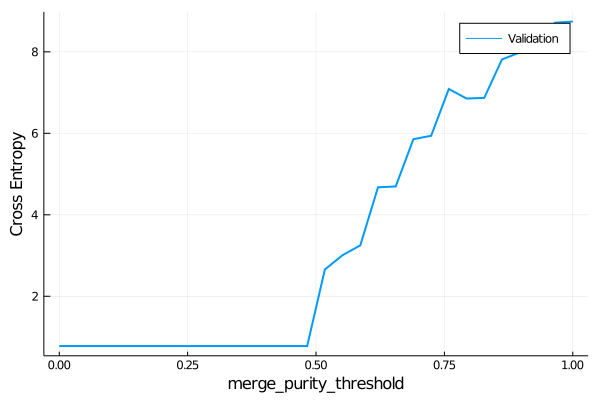

In [79]:
plot(curve.parameter_values,
     curve.measurements,
     xlab=curve.parameter_name,
     ylab="Cross Entropy",
     label="Validation", lw=2)
# plot!(Net2.report.training_losses, label="Training", lw=2)

In [80]:
a = round(minimum(curve.measurements), digits=5)

0.77755

In [81]:
param1 = :merge_purity_threshold

r1 = range(dt, param1, lower=0, upper=1, scale=:linear)

MLJBase.NumericRange(Float64, :merge_purity_threshold, ... )

In [89]:
self_tuning_dt_model = TunedModel(model=dt,
                                    tuning=Grid(goal=100),
                                    resampling=CV(), 
                                    measure=accuracy,
                                    acceleration=CPUThreads(),
                                    range=[r1],
                                    operation=predict_mode)

ProbabilisticTunedModel(
    model = DecisionTreeClassifier(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = 0,
            post_prune = true,
            merge_purity_threshold = 0.8,
            pdf_smoothing = 0.0,
            display_depth = 5),
    tuning = Grid(
            goal = 100,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = accuracy(),
    weights = nothing,
    operation = MLJModelInterface.predict_mode,
    range = MLJBase.NumericRange{Float64,MLJBase.Bounded,Symbol}[NumericRange{Float64,…} @283],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true) @276

In [90]:
self_tuning_dt = machine(self_tuning_dt_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @963 trained 0 times.
  args: 
    1:	Source @083 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @845 ⏎ `AbstractArray{Multiclass{2},1}`


In [91]:
z = fit!(self_tuning_dt, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @963.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 100 metamodels: 100%[=========================] Time: 0:00:04


Machine{ProbabilisticTunedModel{Grid,…}} @963 trained 1 time.
  args: 
    1:	Source @083 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @845 ⏎ `AbstractArray{Multiclass{2},1}`


In [92]:
best = fitted_params(self_tuning_dt)
best

(best_model = DecisionTreeClassifier @020,
 best_fitted_params = (tree = Decision Tree
Leaves: 66
Depth:  14,
                       encoding = Dict{CategoricalValue{String,UInt32},UInt32}("RB" => 0x00000002,"NRB" => 0x00000001),),)

In [93]:
best.best_model

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = true,
    merge_purity_threshold = 0.8686868686868687,
    pdf_smoothing = 0.0,
    display_depth = 5) @020

In [94]:
best_loss = round(z.report.best_result.measurement[1],digits=5)

0.8252

In [95]:
best_mpt = round(best.best_model.merge_purity_threshold,digits=5)

0.86869

In [ ]:
fn = "Figures/LearningCurve_DT_merge_purity_thresh:$(best_mpt)_loss:$(best_loss)"
png(replace(fn,'.' => ','))

### Learning Curve

In [96]:
dt = DecisionTreeClassifier(post_prune=true, merge_purity_threshold=best_mpt)

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = true,
    merge_purity_threshold = 0.86869,
    pdf_smoothing = 0.0,
    display_depth = 5) @195

In [97]:
data_schedule, training_losses, valid_losses = learn_curve(dt, X_stand[train,:], y[train], acc)

(d, train_metric, valid_metric) = (10, 0.9, 0.7027027027027027)
(d, train_metric, valid_metric) = (15, 1.0, 0.6283783783783784)
(d, train_metric, valid_metric) = (20, 1.0, 0.6824324324324325)
(d, train_metric, valid_metric) = (25, 1.0, 0.7297297297297297)
(d, train_metric, valid_metric) = (30, 1.0, 0.7162162162162162)
(d, train_metric, valid_metric) = (35, 1.0, 0.7162162162162162)
(d, train_metric, valid_metric) = (40, 1.0, 0.7364864864864865)
(d, train_metric, valid_metric) = (45, 1.0, 0.7162162162162162)
(d, train_metric, valid_metric) = (50, 0.98, 0.7567567567567568)
(d, train_metric, valid_metric) = (55, 1.0, 0.8243243243243243)
(d, train_metric, valid_metric) = (60, 1.0, 0.7027027027027027)
(d, train_metric, valid_metric) = (65, 0.9846153846153847, 0.75)
(d, train_metric, valid_metric) = (70, 1.0, 0.6959459459459459)
(d, train_metric, valid_metric) = (75, 1.0, 0.6959459459459459)
(d, train_metric, valid_metric) = (80, 0.9875, 0.6959459459459459)
(d, train_metric, valid_metric) = (

(d, train_metric, valid_metric) = (585, 0.9965811965811966, 0.8378378378378378)
(d, train_metric, valid_metric) = (590, 0.9949152542372881, 0.8108108108108109)


(10:5:590, Any[0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98, 1.0  …  0.9963302752293578, 0.9963636363636363, 0.9981981981981982, 0.9982142857142857, 0.9982300884955753, 0.9964912280701754, 0.9965217391304347, 0.9948275862068966, 0.9965811965811966, 0.9949152542372881], Any[0.7027027027027027, 0.6283783783783784, 0.6824324324324325, 0.7297297297297297, 0.7162162162162162, 0.7162162162162162, 0.7364864864864865, 0.7162162162162162, 0.7567567567567568, 0.8243243243243243  …  0.7905405405405406, 0.8040540540540541, 0.8040540540540541, 0.8040540540540541, 0.7905405405405406, 0.8175675675675675, 0.8445945945945946, 0.8108108108108109, 0.8378378378378378, 0.8108108108108109])

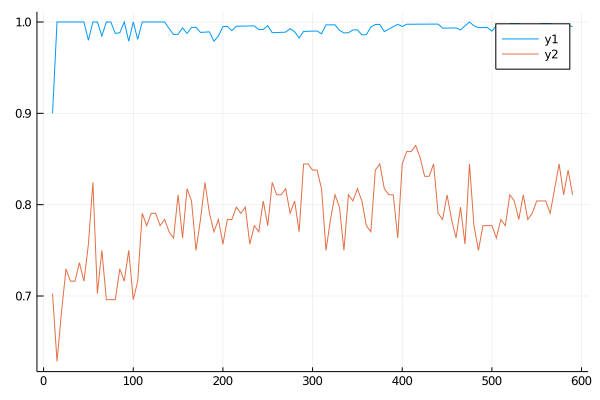

In [98]:
plot(data_schedule, training_losses)
plot!(data_schedule, valid_losses)

# Final Results

In [99]:
final_dt = best.best_model

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = true,
    merge_purity_threshold = 0.8686868686868687,
    pdf_smoothing = 0.0,
    display_depth = 5) @020

In [100]:
Final_Tree = machine(final_dt, X, y)

Machine{DecisionTreeClassifier} @572 trained 0 times.
  args: 
    1:	Source @168 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @446 ⏎ `AbstractArray{Multiclass{2},1}`


In [101]:
fit!(Final_Tree, rows=train, verbosity=2)

Feature 36, Threshold 3.8005
L-> Feature 27, Threshold 2.2380000000000004
    L-> Feature 34, Threshold 2.5
        L-> Feature 9, Threshold 3.5
            L-> Feature 10, Threshold 1.5
                L-> 
                R-> 
            R-> Feature 39, Threshold 8.564
                L-> 1 : 13/13
                R-> 2 : 2/2
        R-> Feature 16, Threshold 1.5
            L-> 1 : 27/27
            R-> Feature 4, Threshold 0.5
                L-> 2 : 5/5
                R-> 1 : 2/2
    R-> Feature 30, Threshold 5.1245
        L-> Feature 18, Threshold 1.1575
            L-> Feature 28, Threshold -0.0015
                L-> 
                R-> 1 : 50/50
            R-> 2 : 2/2
        R-> Feature 11, Threshold 0.5
            L-> Feature 1, Threshold 5.097
                L-> 
                R-> 
            R-> Feature 17, Threshold 1.0225
                L-> 1 : 19/19
                R-> 
R-> Feature 12, Threshold -0.5695
    L-> Feature 22, Threshold 1.2275
        L-> Feature

┌ Info: Training Machine{DecisionTreeClassifier} @572.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{DecisionTreeClassifier} @572 trained 1 time.
  args: 
    1:	Source @168 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @446 ⏎ `AbstractArray{Multiclass{2},1}`


In [102]:
ŷ2 = MLJ.predict(Final_Tree, X[test,:]);

In [103]:
cross_entropy(ŷ2, y[test]) |> mean

5.386669512543516

In [104]:
acc(ŷ2, y[test])

0.8107255520504731

In [105]:
confusion_matrix(mode.(ŷ2), y[test])

┌ Warning: The classes are un-ordered,
│ using: negative='NRB' and positive='RB'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:83


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     NRB     │     RB      │
├─────────────┼─────────────┼─────────────┤
│     NRB     │     174     │     24      │
├─────────────┼─────────────┼─────────────┤
│     RB      │     36      │     83      │
└─────────────┴─────────────┴─────────────┘
